In [1]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt
from scipy import sparse
from scipy.sparse.linalg import spsolve

try:
    from sklearn.linear_model import Lasso
except Exception:
    Lasso = None
from pybaselines import Baseline
plt.rcParams["figure.figsize"] = (14, 4)
plt.rcParams["axes.grid"] = True


In [2]:
def list_doric_channels(path):
    with h5py.File(path, "r") as f:
        base = f["DataAcquisition"]["FPConsole"]["Signals"]["Series0001"]
        chans = []
        if "LockInAOUT02" in base:
            for k in base["LockInAOUT02"].keys():
                if k.startswith("AIN"):
                    chans.append(k)
        chans = sorted(chans)

        digital = []
        if "DigitalIO" in base:
            for k in base["DigitalIO"].keys():
                if k.startswith("DIO"):
                    digital.append(k)
        return chans, digital
def list_doric_files(folder_path):
    """
    Return a list of full paths to all .doric files in the given folder.
    """
    doric_files = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(".doric"):
            doric_files.append(os.path.join(folder_path, fname))
    return doric_files

def load_doric(path, channel="AIN01", signal_folder="LockInAOUT02", ref_folder="LockInAOUT01",
              trigger_name=None):
    """
    Returns dict with:
      time, sig465, ref405, fs, (optional) trig_time, trig
    """
    with h5py.File(path, "r") as f:
        base = f["DataAcquisition"]["FPConsole"]["Signals"]["Series0001"]

        sig = np.asarray(base[signal_folder][channel][()], float)
        ref = np.asarray(base[ref_folder][channel][()], float)

        # time: prefer the matching folder time if size matches
        t_sig = np.asarray(base[signal_folder]["Time"][()], float) if "Time" in base[signal_folder] else np.array([])
        t_ref = np.asarray(base[ref_folder]["Time"][()], float) if "Time" in base[ref_folder] else np.array([])

        if t_sig.size == sig.size:
            t = t_sig
        elif t_ref.size == sig.size:
            t = t_ref
        else:
            # fallback
            dt = np.nanmedian(np.diff(t_sig)) if t_sig.size > 2 else 1/1000
            t = np.arange(sig.size) * dt

        # if ref length differs, interpolate onto t if possible
        if ref.size != sig.size:
            if t_ref.size == ref.size:
                ref = np.interp(t, t_ref, ref)
            else:
                ref = np.resize(ref, sig.size)

        # sampling rate
        fs = 1.0 / float(np.nanmedian(np.diff(t))) if t.size > 2 else np.nan

        # optional digital trigger overlay
        trig_time = None
        trig = None
        if trigger_name:
            if "DigitalIO" in base and trigger_name in base["DigitalIO"]:
                dio = base["DigitalIO"]
                trig = np.asarray(dio[trigger_name][()], float)
                trig_time = np.asarray(dio["Time"][()], float) if "Time" in dio else None

                # if lengths mismatch, interpolate signals to trigger time (like your Doric logic)
                if trig_time is not None and trig_time.size and trig_time.size != t.size:
                    sig = np.interp(trig_time, t, sig)
                    ref = np.interp(trig_time, t, ref)
                    t = trig_time
                    fs = 1.0 / float(np.nanmedian(np.diff(t))) if t.size > 2 else fs

    out = {"time": t, "sig465": sig, "ref405": ref, "fs": fs}
    if trig is not None and trig_time is not None:
        out["trig_time"] = trig_time
        out["trig"] = trig
    return out


In [3]:
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# -----------------------------
# Helpers
# -----------------------------
# =========================
# Cell 2 — Helpers + Robust Fit
# =========================
def _as_float_1d(a):
    return np.asarray(a, dtype=float).ravel()

def mad_sigma(r):
    med = np.median(r)
    return 1.4826 * np.median(np.abs(r - med)) + 1e-12

def huber_irls(x, y, delta=1.5, max_iter=50, tol=1e-10):
    """
    Robust linear fit y ~ a*x + b using Huber IRLS.
    Returns (a, b, sigma_robust).
    """
    x = _as_float_1d(x)
    y = _as_float_1d(y)
    X = np.column_stack([x, np.ones_like(x)])
    beta = np.linalg.lstsq(X, y, rcond=None)[0]  # initial OLS

    for _ in range(max_iter):
        r = y - X @ beta
        s = mad_sigma(r)
        u = r / (s * delta)

        w = np.ones_like(u)
        mask = np.abs(u) > 1
        w[mask] = 1.0 / (np.abs(u[mask]) + 1e-12)

        Xw = X * w[:, None]
        yw = y * w
        beta_new = np.linalg.lstsq(Xw, yw, rcond=None)[0]

        if np.max(np.abs(beta_new - beta)) < tol:
            beta = beta_new
            break
        beta = beta_new

    r = y - X @ beta
    s = mad_sigma(r)
    return float(beta[0]), float(beta[1]), float(s)

def rolling_corr(x, y, win):
    """
    Rolling Pearson correlation in non-overlapping windows of size win.
    Returns corr array and window centers (indices).
    """
    n = min(len(x), len(y))
    nwin = n // win
    if nwin < 2:
        return np.array([]), np.array([])

    x2 = x[:nwin * win].reshape(nwin, win)
    y2 = y[:nwin * win].reshape(nwin, win)

    xmu = x2.mean(axis=1, keepdims=True)
    ymu = y2.mean(axis=1, keepdims=True)
    xv = x2 - xmu
    yv = y2 - ymu
    num = np.sum(xv * yv, axis=1)
    den = np.sqrt(np.sum(xv * xv, axis=1) * np.sum(yv * yv, axis=1)) + 1e-12
    c = num / den

    centers = (np.arange(nwin) * win + win / 2.0)
    return c, centers

def clipping_fraction(a, lo_q=0.001, hi_q=0.999):
    """
    Heuristic clipping: fraction of samples extremely close to extreme quantiles.
    Works even if you don't know ADC min/max.
    """
    a = _as_float_1d(a)
    a = a[np.isfinite(a)]
    if a.size < 10:
        return np.nan, np.nan, np.nan

    lo = np.quantile(a, lo_q)
    hi = np.quantile(a, hi_q)
    span = (hi - lo) + 1e-12
    eps = 0.001 * span
    frac_lo = np.mean(a <= (lo + eps))
    frac_hi = np.mean(a >= (hi - eps))
    return float(frac_lo + frac_hi), float(lo), float(hi)

def flatline_fraction(a, tol=1e-12):
    """
    Fraction of successive differences that are ~0 (flatlining / stuck values).
    """
    a = _as_float_1d(a)
    a = a[np.isfinite(a)]
    if a.size < 3:
        return np.nan
    d = np.diff(a)
    return float(np.mean(np.abs(d) < tol))


In [4]:
# =========================
# Cell 3 — Artifact Detection + Removal (Adaptive MAD)
# =========================
def adaptive_mad_artifact_mask(
    y: np.ndarray,
    fs: float,
    *,
    k: float = 6.0,
    window_s: float = 1.0,
    pad_s: float = 0.2,
    use_derivative: bool = True,
    min_mad: float = 1e-12,
) -> np.ndarray:
    """
    Build an artifact mask using Adaptive MAD (windowed).

    Detection is performed on dx=diff(y) if use_derivative=True, else directly on y.
    Within each non-overlapping window, compute median and MAD, then flag samples where:
        |x - median| > k * MAD

    Mask is returned at signal sample resolution (len(y)).
    """
    y = np.asarray(y, float)
    n = y.size
    if n == 0:
        return np.zeros((0,), dtype=bool)

    if not np.isfinite(fs) or fs <= 0:
        raise ValueError(f"adaptive_mad_artifact_mask: invalid fs={fs}")

    x = np.diff(y) if use_derivative else y.copy()
    nx = x.size
    if nx == 0:
        return np.zeros((n,), dtype=bool)

    win = int(round(window_s * fs))
    win = max(5, win)

    flagged_x = np.zeros((nx,), dtype=bool)

    for start in range(0, nx, win):
        stop = min(start + win, nx)
        seg = x[start:stop]

        seg_f = seg[np.isfinite(seg)]
        if seg_f.size < 5:
            continue

        med = np.median(seg_f)
        mad = np.median(np.abs(seg_f - med))
        mad = max(float(mad), float(min_mad))

        flagged_x[start:stop] = np.abs(seg - med) > (k * mad)

    mask = np.zeros((n,), dtype=bool)
    if use_derivative:
        hit = np.where(flagged_x)[0]
        mask[hit] = True
        mask[hit + 1] = True
    else:
        mask[:nx] = flagged_x

    pad_n = int(round(pad_s * fs))
    if pad_n > 0 and np.any(mask):
        kernel = np.ones((2 * pad_n + 1,), dtype=int)
        mask = (np.convolve(mask.astype(int), kernel, mode="same") > 0)

    return mask

def _nan_interp_1d(y: np.ndarray) -> np.ndarray:
    """
    Linearly interpolate NaNs in a 1D array.
    Edge NaNs are filled with nearest valid value.
    """
    y = np.asarray(y, float).copy()
    n = y.size
    if n == 0:
        return y

    isnan = ~np.isfinite(y)
    if not np.any(isnan):
        return y

    x = np.arange(n)
    good = np.isfinite(y)
    if np.sum(good) == 0:
        return y

    y[isnan] = np.interp(x[isnan], x[good], y[good])
    return y

def remove_artifacts_adaptive_mad(
    time: np.ndarray,
    sig465: np.ndarray,
    ref405: np.ndarray,
    fs: float = None,
    *,
    k: float = 6.0,
    window_s: float = 1.0,
    pad_s: float = 0.2,
    union_channels: bool = True,
    use_derivative: bool = True,
) -> dict:
    """
    Detect + remove artifacts using adaptive MAD (windowed) with padding.

    By default, artifacts are detected on BOTH channels and unioned (recommended),
    then removed from BOTH channels consistently.

    Returns a dict with cleaned signals and the artifact mask/regions.
    """
    t = np.asarray(time, float)
    s = np.asarray(sig465, float)
    r = np.asarray(ref405, float)

    n = min(t.size, s.size, r.size)
    t, s, r = t[:n], s[:n], r[:n]

    if fs is None:
        fs = 1.0 / float(np.nanmedian(np.diff(t))) if t.size > 2 else np.nan
    if not np.isfinite(fs) or fs <= 0:
        raise ValueError(f"remove_artifacts_adaptive_mad: invalid fs={fs}")

    m_s = adaptive_mad_artifact_mask(
        s, fs, k=k, window_s=window_s, pad_s=pad_s, use_derivative=use_derivative
    )
    m_r = adaptive_mad_artifact_mask(
        r, fs, k=k, window_s=window_s, pad_s=pad_s, use_derivative=use_derivative
    )
    mask = (m_s | m_r) if union_channels else m_s

    s_clean = s.copy()
    r_clean = r.copy()
    s_clean[mask] = np.nan
    r_clean[mask] = np.nan

    s_clean = _nan_interp_1d(s_clean)
    r_clean = _nan_interp_1d(r_clean)

    regions = []
    if np.any(mask):
        idx = np.where(mask)[0]
        breaks = np.where(np.diff(idx) > 1)[0]
        starts = np.r_[idx[0], idx[breaks + 1]]
        ends   = np.r_[idx[breaks], idx[-1]]
        for a, b in zip(starts, ends):
            regions.append((float(t[a]), float(t[b])))

    return {
        "time": t,
        "sig465_clean": s_clean,
        "ref405_clean": r_clean,
        "artifact_mask": mask,
        "artifact_regions_s": regions,
        "fs": float(fs),
    }



In [5]:
# =========================
# Cell 4 — QC with Artifact Removal integrated (PDF histogram for residuals)
# =========================
def qc_one_file(
    path,
    rec,
    outdir,
    *,
    # artifact removal params
    do_artifact_removal=True,
    ar_k=6.0,
    ar_window_s=1.0,
    ar_pad_s=0.2,
    ar_union_channels=True,
    ar_use_derivative=True,
    # QC params
    corr_win_seconds=10.0,
    max_plot_points=150_000,
):
    """
    QC is computed AFTER artifact removal (cleaned channels).
    Residual histogram is plotted as a PDF estimate (density=True) and overlaid with
    a Gaussian KDE (if SciPy supports it in your environment).
    """
    # --- load raw ---
    t_raw = _as_float_1d(rec["time"])
    sig_raw = _as_float_1d(rec["sig465"])
    ref_raw = _as_float_1d(rec["ref405"])
    fs = float(rec.get("fs", np.nan))

    n0 = min(len(t_raw), len(sig_raw), len(ref_raw))
    t_raw, sig_raw, ref_raw = t_raw[:n0], sig_raw[:n0], ref_raw[:n0]

    finite = np.isfinite(t_raw) & np.isfinite(sig_raw) & np.isfinite(ref_raw)
    t_raw, sig_raw, ref_raw = t_raw[finite], sig_raw[finite], ref_raw[finite]
    n = len(t_raw)

    # --- time sanity on raw timebase ---
    dt = np.diff(t_raw)
    dt_med = np.median(dt) if dt.size else np.nan
    dt_mad = mad_sigma(dt - np.median(dt)) if dt.size else np.nan
    nonmono_frac = float(np.mean(dt <= 0)) if dt.size else np.nan

    # --- artifact removal ---
    if do_artifact_removal:
        ar = remove_artifacts_adaptive_mad(
            t_raw,
            sig_raw,
            ref_raw,
            fs=fs if np.isfinite(fs) and fs > 0 else None,
            k=ar_k,
            window_s=ar_window_s,
            pad_s=ar_pad_s,
            union_channels=ar_union_channels,
            use_derivative=ar_use_derivative,
        )
        t = ar["time"]
        sig = ar["sig465_clean"]
        ref = ar["ref405_clean"]
        art_mask = ar["artifact_mask"]
        art_regions = ar["artifact_regions_s"]
        fs_eff = ar["fs"]
    else:
        t, sig, ref = t_raw, sig_raw, ref_raw
        art_mask = np.zeros_like(t, dtype=bool)
        art_regions = []
        fs_eff = fs if np.isfinite(fs) else (1.0 / np.nanmedian(np.diff(t)) if t.size > 2 else np.nan)

    # --- global pearson on cleaned ---
    r_global, p_global = pearsonr(ref, sig)

    # --- robust regression + residuals (cleaned) ---
    a, b, s_rob = huber_irls(ref, sig, delta=1.5)
    pred = a * ref + b
    resid = sig - pred

    # Outliers on cleaned residual
    outlier_z = resid / (s_rob + 1e-12)
    outlier_mask = np.abs(outlier_z) > 6.0
    outlier_frac = float(np.mean(outlier_mask))

    # Rolling correlation on cleaned
    if np.isfinite(fs_eff) and fs_eff > 0:
        win = int(max(10, round(fs_eff * corr_win_seconds)))
    else:
        win = 5000
    r_roll, centers = rolling_corr(ref, sig, win=win)
    r_roll_med = float(np.nanmedian(r_roll)) if r_roll.size else np.nan
    r_roll_min = float(np.nanmin(r_roll)) if r_roll.size else np.nan
    pct_roll_gt_05 = float(np.mean(r_roll > 0.5) * 100.0) if r_roll.size else np.nan

    # Clipping/flatline heuristics on cleaned
    clip_sig, sig_lo, sig_hi = clipping_fraction(sig)
    clip_ref, ref_lo, ref_hi = clipping_fraction(ref)
    flat_sig = flatline_fraction(sig)
    flat_ref = flatline_fraction(ref)

    # Regime change: robust slope in first vs second half (cleaned)
    mid = n // 2
    a1, b1, s1 = huber_irls(ref[:mid], sig[:mid], delta=1.5) if mid > 1000 else (np.nan, np.nan, np.nan)
    a2, b2, s2 = huber_irls(ref[mid:], sig[mid:], delta=1.5) if (n - mid) > 1000 else (np.nan, np.nan, np.nan)
    slope_change = float(np.abs(a2 - a1) / (np.abs(a) + 1e-12)) if np.isfinite(a1) and np.isfinite(a2) else np.nan

    # Artifact removal stats
    art_frac = float(np.mean(art_mask)) if art_mask.size else 0.0

    # --- Residual summary stats (for histogram + AUC) ---
    resid_f = resid[np.isfinite(resid)]
    if resid_f.size:
        q25, q50, q75 = np.quantile(resid_f, [0.25, 0.50, 0.75])
        iqr = q75 - q25
        halfwidth = 0.5 * iqr
    else:
        q25 = q50 = q75 = iqr = halfwidth = np.nan

    # AUC over time
    if t.size >= 2 and resid_f.size:
        auc_signed = float(np.trapz(resid, t))
        auc_abs = float(np.trapz(np.abs(resid), t))
        duration = float(t[-1] - t[0])
        auc_signed_per_s = auc_signed / duration if duration > 0 else np.nan
        auc_abs_per_s = auc_abs / duration if duration > 0 else np.nan
    else:
        auc_signed = auc_abs = auc_signed_per_s = auc_abs_per_s = np.nan

    # Decision logic (unchanged)
    flags = []
    if nonmono_frac > 0:
        flags.append("TIME_NON_MONOTONIC")
    if do_artifact_removal and art_frac > 0.02:
        flags.append("MANY_ARTIFACTS_REMOVED")
    if np.isfinite(clip_sig) and clip_sig > 0.005:
        flags.append("SIG_CLIPPING")
    if np.isfinite(clip_ref) and clip_ref > 0.005:
        flags.append("REF_CLIPPING")
    if np.isfinite(flat_sig) and flat_sig > 0.01:
        flags.append("SIG_FLATLINE")
    if np.isfinite(flat_ref) and flat_ref > 0.01:
        flags.append("REF_FLATLINE")
    if np.isfinite(r_roll_med) and r_roll_med < 0.75:
        flags.append("LOW_ROLLING_CORR")
    if np.isfinite(r_roll_min) and r_roll_min < 0.3:
        flags.append("ROLLING_CORR_DROPS")
    if np.isfinite(outlier_frac) and outlier_frac > 0.01:
        flags.append("MANY_OUTLIERS")
    if np.isfinite(slope_change) and slope_change > 0.25:
        flags.append("SLOPE_REGIME_CHANGE")

    if any(f in flags for f in ["TIME_NON_MONOTONIC", "SIG_CLIPPING", "REF_CLIPPING", "SIG_FLATLINE", "REF_FLATLINE"]):
        qc_class = "FAIL"
    elif any(f in flags for f in ["LOW_ROLLING_CORR", "ROLLING_CORR_DROPS", "MANY_OUTLIERS", "SLOPE_REGIME_CHANGE", "MANY_ARTIFACTS_REMOVED"]):
        qc_class = "WARN"
    else:
        qc_class = "PASS"

    # -----------------------------
    # Plotting
    # -----------------------------
    fname = Path(path).stem
    outdir = Path(outdir)
    outdir.mkdir(parents=True, exist_ok=True)

    if n > max_plot_points:
        idx = np.linspace(0, n - 1, max_plot_points).astype(int)
    else:
        idx = np.arange(n)

    # scatter downsample + keep outliers
    idx_sc = idx
    if outlier_mask.any():
        out_idx = np.where(outlier_mask)[0]
        idx_sc = np.unique(np.concatenate([idx_sc, out_idx]))
        if idx_sc.size > max_plot_points:
            in_idx = idx_sc[~outlier_mask[idx_sc]]
            kkeep = max_plot_points - out_idx.size
            if kkeep > 0 and in_idx.size > kkeep:
                keep_in = np.random.choice(in_idx, size=kkeep, replace=False)
                idx_sc = np.unique(np.concatenate([keep_in, out_idx]))
            else:
                idx_sc = out_idx

    ref_sc = ref[idx_sc]
    sig_sc = sig[idx_sc]
    out_sc = outlier_mask[idx_sc]

    fig = plt.figure(figsize=(14, 9), dpi=150)
    gs = fig.add_gridspec(3, 3, height_ratios=[1.0, 1.0, 1.0])

    ax0 = fig.add_subplot(gs[0, :])     # cleaned timeseries (twin y)
    ax1 = fig.add_subplot(gs[1, 0:2])   # scatter
    ax2 = fig.add_subplot(gs[1, 2])     # residual PDF
    ax3 = fig.add_subplot(gs[2, 0:2])   # residual time
    ax4 = fig.add_subplot(gs[2, 2])     # rolling corr

    # A) cleaned signals with twin y-axis
    ax0_sig = ax0
    ax0_ref = ax0_sig.twinx()

    l1 = ax0_sig.plot(t[idx], sig[idx], lw=0.7, alpha=0.95, color="C0", label="sig465 cleaned")
    l2 = ax0_ref.plot(t[idx], ref[idx], lw=0.7, alpha=0.80, color="C1", label="ref405 cleaned")

    if do_artifact_removal and art_regions:
        for (t0, t1) in art_regions[:20]:
            ax0_sig.axvspan(t0, t1, color="crimson", alpha=0.05)

    ax0_sig.set_title(f"{fname} | QC={qc_class} | flags={','.join(flags) if flags else 'none'}")
    ax0_sig.set_xlabel("time (s)")
    ax0_sig.set_ylabel("sig465 (cleaned)", color="C0")
    ax0_ref.set_ylabel("ref405 (cleaned)", color="C1")
    ax0_sig.grid(True, alpha=0.25)

    lines = l1 + l2
    labels = [ln.get_label() for ln in lines]
    ax0_sig.legend(lines, labels, loc="upper right", fontsize=8)

    # B) scatter + robust fit
    ax1.scatter(ref_sc[~out_sc], sig_sc[~out_sc], s=6, alpha=0.25, edgecolor="none", label="inliers")
    if out_sc.any():
        ax1.scatter(ref_sc[out_sc], sig_sc[out_sc], s=10, alpha=0.75, c="crimson", edgecolor="none", label="outliers")
    xline = np.linspace(np.nanmin(ref_sc), np.nanmax(ref_sc), 200)
    ax1.plot(xline, a * xline + b, lw=2.0, label="robust fit (Huber)")
    ax1.set_xlabel("ref405 (cleaned)")
    ax1.set_ylabel("sig465 (cleaned)")
    ax1.grid(True, alpha=0.25)
    ax1.legend(loc="best", fontsize=8)

    stats_txt = (
        f"n={n}\n"
        f"Pearson r={r_global:.4f}\n"
        f"artifact removed={art_frac*100:.2f}%  regions={len(art_regions)}\n"
        f"rolling r med={r_roll_med:.3f}, min={r_roll_min:.3f}\n"
        f"% windows r>0.5 = {pct_roll_gt_05:.1f}%\n"
        f"fit: sig={a:.4g}*ref + {b:.4g}\n"
        f"robust σ(resid)={s_rob:.4g}\n"
        f"outliers(|z|>6)={outlier_frac*100:.2f}%\n"
        f"slope change (half/half)={slope_change:.2f}\n"
        f"fs={fs_eff:.3f}"
    )
    ax1.text(
        0.02, 0.98, stats_txt,
        transform=ax1.transAxes, va="top", ha="left",
        bbox=dict(boxstyle="round,pad=0.35", facecolor="white", alpha=0.9, edgecolor="0.7"),
        fontsize=8
    )

    # C) residual distribution as PDF estimate
    resid_plot = resid[idx]
    resid_plot = resid_plot[np.isfinite(resid_plot)]
    ax2.set_title("Residual PDF estimate")
    ax2.set_xlabel("resid = sig - (a*ref+b)")
    ax2.set_ylabel("density")
    ax2.grid(True, alpha=0.25)

    if resid_plot.size:
        # PDF via normalized histogram
        ax2.hist(resid_plot, bins=80, density=True, color="0.6", alpha=0.55, edgecolor="none", label="hist PDF")

        # KDE overlay if available (scipy installed already; this is safe)
        try:
            from scipy.stats import gaussian_kde
            kde = gaussian_kde(resid_plot)
            xs = np.linspace(np.quantile(resid_plot, 0.001), np.quantile(resid_plot, 0.999), 400)
            ax2.plot(xs, kde(xs), color="C0", lw=2, label="KDE")
        except Exception:
            pass

        # quantile annotations
        ax2.axvline(q50, color="C0", lw=2, label="median")
        ax2.axvspan(q25, q75, color="C0", alpha=0.12, label="25–75%")

        pdf_txt = (
            f"median={q50:.4g}\n"
            f"q25={q25:.4g}, q75={q75:.4g}\n"
            f"IQR={iqr:.4g}\n"
            f"halfwidth=IQR/2={halfwidth:.4g}"
        )
        ax2.text(
            0.02, 0.98, pdf_txt,
            transform=ax2.transAxes, va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.30", facecolor="white", alpha=0.9, edgecolor="0.7"),
            fontsize=8
        )
        ax2.legend(loc="best", fontsize=8)

    # D) residual vs time + AUC
    ax3.plot(t[idx], resid[idx], lw=0.6, alpha=0.95)
    ax3.axhline(0, color="k", lw=1, alpha=0.5)
    ax3.set_title("Residual over time (cleaned)")
    ax3.set_xlabel("time (s)")
    ax3.set_ylabel("residual")
    ax3.grid(True, alpha=0.25)

    auc_txt = (
        f"AUC signed={auc_signed:.4g}\n"
        f"AUC abs={auc_abs:.4g}\n"
        f"signed/s={auc_signed_per_s:.4g}\n"
        f"abs/s={auc_abs_per_s:.4g}"
    )
    ax3.text(
        0.02, 0.98, auc_txt,
        transform=ax3.transAxes, va="top", ha="left",
        bbox=dict(boxstyle="round,pad=0.30", facecolor="white", alpha=0.9, edgecolor="0.7"),
        fontsize=8
    )

    # E) rolling corr + annotate %>0.5
    if r_roll.size:
        t_cent = t[(centers.astype(int)).clip(0, n - 1)]
        ax4.plot(t_cent, r_roll, lw=1.0)
        ax4.axhline(0.5, color="0.3", lw=1, ls="--", alpha=0.7)
        ax4.axhline(0.75, color="orange", lw=1, ls="--", alpha=0.8)
        ax4.axhline(0.3, color="crimson", lw=1, ls="--", alpha=0.8)
        ax4.set_ylim(-1.05, 1.05)

        ax4.text(
            0.02, 0.98,
            f"% windows r>0.5: {pct_roll_gt_05:.1f}%",
            transform=ax4.transAxes,
            va="top", ha="left",
            bbox=dict(boxstyle="round,pad=0.25", facecolor="white", alpha=0.9, edgecolor="0.7"),
            fontsize=8,
        )

    ax4.set_title(f"Rolling corr (cleaned, {corr_win_seconds:.0f}s windows)")
    ax4.set_xlabel("time (s)")
    ax4.set_ylabel("r")
    ax4.grid(True, alpha=0.25)

    fig.tight_layout()
    outpath = outdir / f"{fname}_QC_cleaned.png"
    fig.savefig(outpath, bbox_inches="tight")
    plt.close(fig)

    return dict(
        file=Path(path).name,
        qc_class=qc_class,
        flags=",".join(flags),
        n=n,
        fs=fs_eff,
        pearson_r=r_global,
        rolling_r_median=r_roll_med,
        rolling_r_min=r_roll_min,
        rolling_pct_gt_05=pct_roll_gt_05,
        slope=a,
        intercept=b,
        robust_sigma=s_rob,
        outlier_frac=outlier_frac,
        clip_sig=clip_sig,
        clip_ref=clip_ref,
        flat_sig=flat_sig,
        flat_ref=flat_ref,
        slope_change_half=slope_change,
        dt_median=dt_med,
        dt_mad=dt_mad,
        nonmono_frac=nonmono_frac,
        artifact_frac=art_frac,
        n_artifact_regions=len(art_regions),
        resid_auc_signed=auc_signed,
        resid_auc_abs=auc_abs,
        resid_auc_signed_per_s=auc_signed_per_s,
        resid_auc_abs_per_s=auc_abs_per_s,
        resid_q25=q25,
        resid_median=q50,
        resid_q75=q75,
        resid_iqr=iqr,
        resid_halfwidth=halfwidth,
        qc_figure=str(outpath),
    )


In [6]:
# =========================
# Cell 5 — Folder runner (QC after artifact removal)
# =========================
def qc_folder(
    folder,
    doric_paths,
    load_doric,
    *,
    out_subdir="QC_reports",
    # artifact removal params
    do_artifact_removal=True,
    ar_k=6.0,
    ar_window_s=1.0,
    ar_pad_s=0.2,
    ar_union_channels=True,
    ar_use_derivative=True,
    # QC params
    corr_win_seconds=10.0,
    max_plot_points=150_000,
):
    folder = Path(folder)
    outdir = folder / out_subdir
    outdir.mkdir(parents=True, exist_ok=True)

    all_metrics = []
    for path in doric_paths:
        rec = load_doric(path)
        m = qc_one_file(
            path, rec, outdir,
            do_artifact_removal=do_artifact_removal,
            ar_k=ar_k, ar_window_s=ar_window_s, ar_pad_s=ar_pad_s,
            ar_union_channels=ar_union_channels, ar_use_derivative=ar_use_derivative,
            corr_win_seconds=corr_win_seconds,
            max_plot_points=max_plot_points,
        )
        all_metrics.append(m)
        print(
            f"{m['qc_class']:4s}  {m['file']}  "
            f"art%={100*m['artifact_frac']:.2f}  r={m['pearson_r']:.3f}  "
            f"roll_med={m['rolling_r_median']:.3f}  flags={m['flags'] if m['flags'] else 'none'}  "
            f"fig={Path(m['qc_figure']).name}"
        )

    print("\n--- QC Summary ---")
    for m in all_metrics:
        print(
            f"{m['qc_class']:4s}  {m['file']:<18s} "
            f"art%={100*m['artifact_frac']:.2f}  "
            f"r={m['pearson_r']:.3f}  roll_med={m['rolling_r_median']:.3f}  "
            f"out%={100*m['outlier_frac']:.2f}  "
            f"slopechg={m['slope_change_half']:.2f}  flags={m['flags']}"
        )

    return all_metrics


In [7]:
# =========================
# Cell 6 — Run on your data
# =========================
folder = r"C:\Analysis\fiber_photometry_app\test_data\lick_edited"
doric_paths = list_doric_files(folder)

metrics = qc_folder(
    folder,
    doric_paths,
    load_doric,
    out_subdir="QC_reports_withArtifactRemoval",
    do_artifact_removal=True,
    ar_k=6.0,
    ar_window_s=1.0,
    ar_pad_s=0.2,
    ar_union_channels=True,
    ar_use_derivative=True,
    corr_win_seconds=10.0,
)


C:\Users\andrianj\AppData\Local\Temp\ipykernel_4836768\2560931167.py:118: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_signed = float(np.trapz(resid, t))
C:\Users\andrianj\AppData\Local\Temp\ipykernel_4836768\2560931167.py:119: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_abs = float(np.trapz(np.abs(resid), t))


WARN  30545-lickedit.doric  art%=0.00  r=0.989  roll_med=0.239  flags=LOW_ROLLING_CORR,ROLLING_CORR_DROPS,SLOPE_REGIME_CHANGE  fig=30545-lickedit_QC_cleaned.png
WARN  30546-lickedit.doric  art%=0.00  r=0.992  roll_med=0.290  flags=LOW_ROLLING_CORR,ROLLING_CORR_DROPS,SLOPE_REGIME_CHANGE  fig=30546-lickedit_QC_cleaned.png
WARN  30547-lickedit.doric  art%=0.00  r=0.987  roll_med=0.146  flags=LOW_ROLLING_CORR,ROLLING_CORR_DROPS  fig=30547-lickedit_QC_cleaned.png
WARN  30549-lickedit.doric  art%=0.11  r=0.989  roll_med=0.576  flags=LOW_ROLLING_CORR,ROLLING_CORR_DROPS,MANY_OUTLIERS  fig=30549-lickedit_QC_cleaned.png

--- QC Summary ---
WARN  30545-lickedit.doric art%=0.00  r=0.989  roll_med=0.239  out%=0.01  slopechg=0.28  flags=LOW_ROLLING_CORR,ROLLING_CORR_DROPS,SLOPE_REGIME_CHANGE
WARN  30546-lickedit.doric art%=0.00  r=0.992  roll_med=0.290  out%=0.38  slopechg=0.37  flags=LOW_ROLLING_CORR,ROLLING_CORR_DROPS,SLOPE_REGIME_CHANGE
WARN  30547-lickedit.doric art%=0.00  r=0.987  roll_med=0.14

In [8]:
# slice for plotting
t_plot = t_ds[mask]

def sl(x):  # slice helper
    return np.asarray(x)[mask]

fig, ax = plt.subplots()
ax.plot(t_plot, sl(out_air["sig_det"]),  lw=1, label="465 detrended airPLS")
ax.plot(t_plot, sl(out_asls["sig_det"]), lw=1, label="465 detrended AsLS")
ax.plot(t_plot, sl(out_arpls["sig_det"]),lw=1, label="465 detrended arPLS")
ax.set_title("465 detrended comparison")
ax.set_xlabel("Time (s)")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(t_plot, sl(out_air["ref_det"]),  lw=1, label="405 detrended airPLS")
ax.plot(t_plot, sl(out_asls["ref_det"]), lw=1, label="405 detrended AsLS")
ax.plot(t_plot, sl(out_arpls["ref_det"]),lw=1, label="405 detrended arPLS")
ax.set_title("405 detrended comparison")
ax.set_xlabel("Time (s)")
ax.legend()
plt.show()


NameError: name 't_ds' is not defined

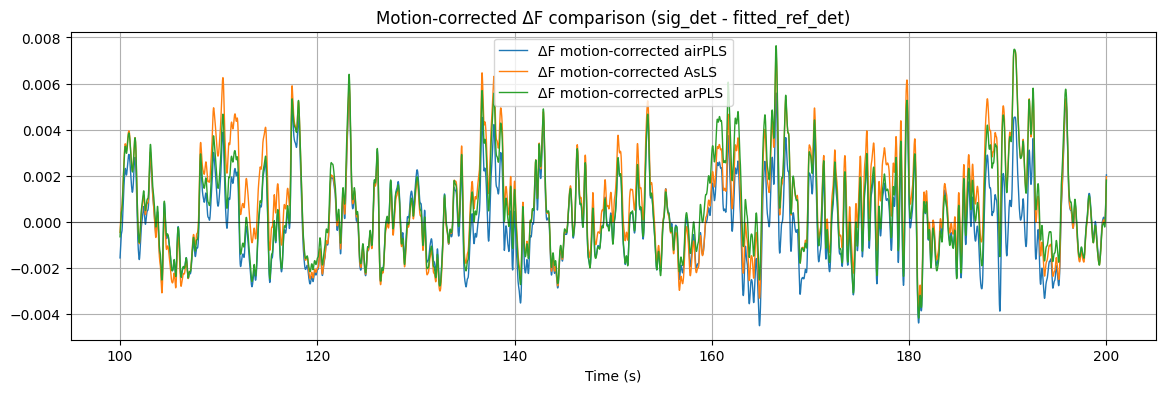

In [83]:
fig, ax = plt.subplots()
ax.plot(t_plot, sl(out_air["delta_mc"]),  lw=1, label="ΔF motion-corrected airPLS")
ax.plot(t_plot, sl(out_asls["delta_mc"]), lw=1, label="ΔF motion-corrected AsLS")
ax.plot(t_plot, sl(out_arpls["delta_mc"]),lw=1, label="ΔF motion-corrected arPLS")
ax.axhline(0, color="k", lw=0.8, alpha=0.5)
ax.set_title("Motion-corrected ΔF comparison (sig_det - fitted_ref_det)")
ax.set_xlabel("Time (s)")
ax.legend()
plt.show()


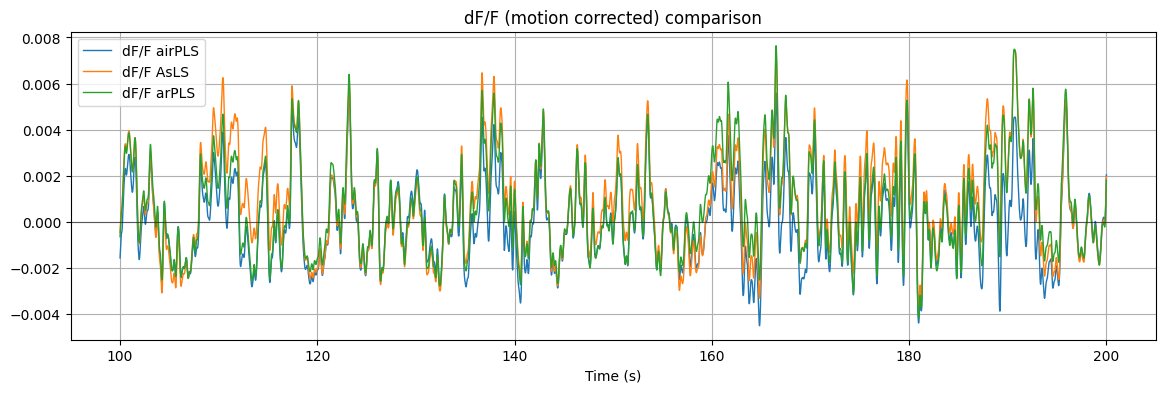

In [84]:
fig, ax = plt.subplots()
ax.plot(t_plot, sl(out_air["dff"]),  lw=1, label="dF/F airPLS")
ax.plot(t_plot, sl(out_asls["dff"]), lw=1, label="dF/F AsLS")
ax.plot(t_plot, sl(out_arpls["dff"]),lw=1, label="dF/F arPLS")
ax.axhline(0, color="k", lw=0.8, alpha=0.5)
ax.set_title("dF/F (motion corrected) comparison")
ax.set_xlabel("Time (s)")
ax.legend()
plt.show()


In [85]:
def rms(x):
    x = np.asarray(x, float)
    x = x[np.isfinite(x)]
    return float(np.sqrt(np.mean(x**2))) if x.size else np.nan

def corr(a, b):
    a = np.asarray(a, float); b = np.asarray(b, float)
    m = np.isfinite(a) & np.isfinite(b)
    if np.sum(m) < 10:
        return np.nan
    aa = a[m] - np.mean(a[m])
    bb = b[m] - np.mean(b[m])
    denom = np.sqrt(np.sum(aa**2) * np.sum(bb**2))
    return float(np.sum(aa*bb) / denom) if denom > 0 else np.nan

d_air  = sl(out_air["dff"])
d_asls = sl(out_asls["dff"])
d_arpls= sl(out_arpls["dff"])

print("Windowed dF/F metrics:")
print("RMS:", "airPLS", rms(d_air), "AsLS", rms(d_asls), "arPLS", rms(d_arpls))
print("corr(air, asls) =", corr(d_air, d_asls))
print("corr(air, arpls)=", corr(d_air, d_arpls))
print("corr(asls, arpls)=", corr(d_asls, d_arpls))


Windowed dF/F metrics:
RMS: airPLS 0.0017510362873541093 AsLS 0.0022508290323248912 arPLS 0.002100974973815439
corr(air, asls) = 0.9226048795881723
corr(air, arpls)= 0.9308502240798334
corr(asls, arpls)= 0.9488152792277463
